## BERT Modelling

Note that due to hardware limitations, this notebook was run inside of google collab and the model is downloaded and imported to 5. Modelling/bert_model

In [3]:
import pandas as pd

In [4]:
train_df = pd.read_csv(r'/content/train_data.csv', header=0)
test_df = pd.read_csv(r'/content/test_data.csv', header=0)

print(train_df.head())
print(test_df.head())

                                                Text  Target
0  meme if i cation proceeds although some intern...     1.0
1                             set everything on fire     1.0
2  determination a the drive force propel me forw...     0.0
3  stride with confidence footprint of self assur...     0.0
4  i bet i feel like school shoot tomorrow i also...     2.0
                                                Text  Target
0  and i kill want you all here one day i hate pe...     2.0
1  have a string of bad luck with constant techno...     0.0
2  man call on police him claim to also have shot...     2.0
3                  this shoot lighting up the school     2.0
4  i i f hate victim i s name she i s full of so ...     2.0


In [12]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix, auc, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, label_binarize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [6]:
# Encode string labels to integers if necessary
label_encoder = LabelEncoder()
train_df['Target'] = label_encoder.fit_transform(train_df['Target'])
test_df['Target'] = label_encoder.transform(test_df['Target'])

NUM_CLASSES = len(label_encoder.classes_)

In [7]:
# define and tokenize dataset

# Define Dataset
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_len)
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

# Tokenize
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_dataset = TextDataset(train_df['Text'].tolist(), train_df['Target'].tolist(), tokenizer)
test_dataset = TextDataset(test_df['Text'].tolist(), test_df['Target'].tolist(), tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [8]:

# Load BERT model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=NUM_CLASSES)
model.to(device)

# Training Loop
optimizer = AdamW(model.parameters(), lr=2e-5)

EPOCHS = 3
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()

    print(f"Epoch {epoch+1} loss: {total_loss/len(train_loader)}")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training Epoch 1: 100%|██████████| 267/267 [01:25<00:00,  3.14it/s]


Epoch 1 loss: 0.4333416852500108


Training Epoch 2: 100%|██████████| 267/267 [01:28<00:00,  3.00it/s]


Epoch 2 loss: 0.14676088636761972


Training Epoch 3: 100%|██████████| 267/267 [01:30<00:00,  2.94it/s]

Epoch 3 loss: 0.06966990069573403


Evaluating: 100%|██████████| 58/58 [00:10<00:00,  5.34it/s]



--- Classification Report ---
              precision    recall  f1-score   support

           0       0.93      0.90      0.92       617
           1       0.90      0.86      0.88       613
           2       0.92      1.00      0.96       601

    accuracy                           0.92      1831
   macro avg       0.92      0.92      0.92      1831
weighted avg       0.92      0.92      0.92      1831

Accuracy:  0.9186237028945932
F1 Score (weighted):  0.9178362291861051
ROC AUC (macro): 0.9854

--- Confusion Matrix ---


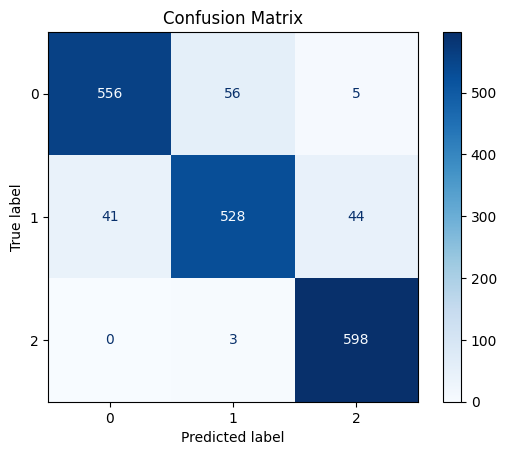

In [14]:
# 8. Evaluation
model.eval()
all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        probs = torch.softmax(logits, dim=1).cpu().numpy()
        preds = np.argmax(probs, axis=1)

        all_probs.extend(probs)
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

# Metrics
accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')

# For ROC AUC
y_true_bin = label_binarize(all_labels, classes=list(range(NUM_CLASSES)))
roc_auc = roc_auc_score(y_true_bin, all_probs, average="macro", multi_class="ovr")

# Add Classification Report
print("\n--- Classification Report ---")
print(classification_report(all_labels, all_preds))

print(f"Accuracy: ", accuracy_score(all_labels, all_preds))
print(f"F1 Score (weighted): ", f1_score(all_labels, all_preds, average='weighted'))

print(f"ROC AUC (macro): {roc_auc:.4f}")

# confusion matrix
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

In [16]:
# Save to folder
model.save_pretrained('./saved_bert_model')
tokenizer.save_pretrained('./saved_bert_model')

('./saved_bert_model/tokenizer_config.json',
 './saved_bert_model/special_tokens_map.json',
 './saved_bert_model/vocab.txt',
 './saved_bert_model/added_tokens.json')

In [17]:
import shutil

# Zip the folder
shutil.make_archive('bert_model', 'zip', 'saved_bert_model')

from google.colab import files

# Download the zip file to your local machine
files.download('bert_model.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>